In [6]:
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
# This one is for paraphrasing
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [7]:
torch.backends.cuda.matmul.allow_tf32 = True

In [25]:
tokenizer = AutoTokenizer.from_pretrained("prithivida/parrot_paraphraser_on_T5")
model = AutoModelForSeq2SeqLM.from_pretrained("prithivida/parrot_paraphraser_on_T5")

In [26]:
model.to('cuda');

In [27]:
dataset = load_dataset("csv", data_files='./Paraphraser Train.csv')
dataset = dataset['train']

Found cached dataset csv (C:/Users/vmpletsos/.cache/huggingface/datasets/csv/default-d4c41a77edc2baed/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


In [32]:
epochs = 20
max_length = 1026
task_prefix = "paraphrase: "
batch_size = 16
gradient_accumulations_steps = 0

In [33]:
dataset_length = len(dataset)

In [34]:
optimizer = optim.Adam(
            params=model.parameters(),
            lr=1e-5,
            betas=(0.9, 0.999),
            eps=1e-08,
            amsgrad=False,
            weight_decay=1e-5
        )

In [35]:
losses = []
for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    epoch_loss = 0
    j = 0
    while j < dataset_length:
        if j + batch_size > dataset_length:
            originals = dataset[j:len(dataset)]['original']
            paraphrases = dataset[j:len(dataset)]['paraphrase']
        else:
            originals = dataset[j:j + batch_size]['original']
            paraphrases = dataset[j:j + batch_size]['paraphrase']
        j += batch_size 
        
        encoding = tokenizer(
            [task_prefix + original for original in originals],
            padding="longest",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
        
        target_encoding = tokenizer(
            paraphrases,
            padding="longest",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        labels = target_encoding.input_ids
        # replace padding token id's of the labels by -100 so it's ignored by the loss
        labels[labels == tokenizer.pad_token_id] = -100
        
        # Zero the gradients
        optimizer.zero_grad()
        
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
        labels = labels.to('cuda')
        
        # forward pass
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
        epoch_loss += loss.item()
        loss.backward()
        # (loss / gradient_accumulations_steps).backward()
        
        optimizer.step()
        # # Backward pass and optimization step
        # if (j+1) % gradient_accumulations_steps == 0:
        #     model.zero_grad()
    print('Epoch', epoch+1, 'Loss/train', epoch_loss/dataset_length)
    losses.append(epoch_loss/dataset_length)
    

Epoch 1 Loss/train 0.07988641552022986
Epoch 2 Loss/train 0.07657595314421095
Epoch 3 Loss/train 0.07182532871091687
Epoch 4 Loss/train 0.0702965936145267
Epoch 5 Loss/train 0.06843806440765793
Epoch 6 Loss/train 0.06547714675868954
Epoch 7 Loss/train 0.06315946578979492
Epoch 8 Loss/train 0.060984714074177784
Epoch 9 Loss/train 0.06222971119322218
Epoch 10 Loss/train 0.059462761556780014
Epoch 11 Loss/train 0.05753916018717998
Epoch 12 Loss/train 0.05678482420809634
Epoch 13 Loss/train 0.05657145085635486
Epoch 14 Loss/train 0.053986926336546205
Epoch 15 Loss/train 0.05292409067755347
Epoch 16 Loss/train 0.05214990474082328
Epoch 17 Loss/train 0.052843397265082005
Epoch 18 Loss/train 0.04940627126006393
Epoch 19 Loss/train 0.049330980928094535
Epoch 20 Loss/train 0.04787724028836499


In [36]:
# get 2 instructions from the dataset
questions = ['How to maintain marble with cracks?', 'How to remove rust stains from corroded connectors?', 'Will the project be finished on time and everything will be ok']
question_inputs = tokenizer([task_prefix + question for question in questions], return_tensors="pt", padding=True)
question_inputs = question_inputs.to('cuda')

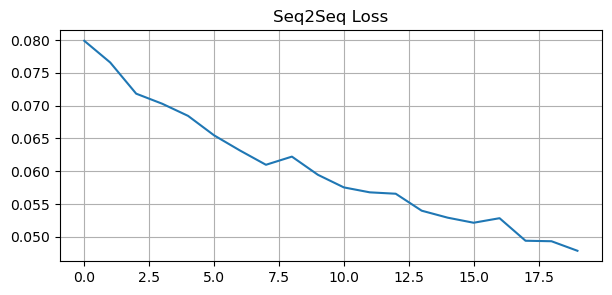

In [44]:
plt.figure(figsize=(7,3))
plt.title('Seq2Seq Loss')
plt.plot(losses)
plt.grid()

In [49]:
preds = model.generate(
              question_inputs['input_ids'],
              do_sample=False, 
              max_length=max_length, 
              num_beams = 10,
              num_beam_groups = 2,
              diversity_penalty = 2.0,
              early_stopping=True,
              num_return_sequences=10
              )

In [50]:
predicted_answers = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [51]:
predicted_answers

['How to maintain marble with cracks?',
 'How to protect marble with cracks?',
 'How to keep marble with cracks?',
 'How to keep marble without cracks?',
 'How do you fix cracks in marble?',
 'Is there a way to maintain marble with cracks?',
 'Is there a way to keep marble with cracks?',
 'Is there any way to prevent cracks in marble?',
 'Is there a way to maintain marble without cracks?',
 'Is there a way to repair marble with cracks?',
 'How to remove rust stains from corroded connectors?',
 'How do I remove rust stains from corroded connectors?',
 'How do you remove rust stains from corroded connectors?',
 'How to remove rust from corroded connectors?',
 'Tell me the best way to remove rust from corroded connectors?',
 'How to remove rust stains from corroded connectors',
 'How to remove rust stains from corroded connectors? ',
 'How to remove rust stains from corroded connectors??',
 'How rust can be removed from corroded connectors?',
 'How rust can be removed from corroded connec